In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers import Input, Dense, Dropout, Activation, Add, Concatenate, Conv2D, Conv2DTranspose, UpSampling2D, MaxPooling2D, MaxPool2D, Flatten, BatchNormalization
from keras import regularizers
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import SGD, Adam, RMSprop, Adadelta
import keras.backend as K
from keras.objectives import mean_squared_error
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils, to_categorical
from keras.datasets import cifar10

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

Using TensorFlow backend.


In [2]:
(X_train_images, y_train_labels), (X_test_images, y_test_labels) = cifar10.load_data()

print('X_train_images.shape: ', X_train_images.shape)
print('X_test_images.shape: ', X_test_images.shape)
print('y_train_labels.shape: ', y_train_labels.shape)
print('y_test_labels.shape: ', y_test_labels.shape)

170500096/170498071 [==============================] - 14s 0us/step
X_train_images.shape:  (50000, 32, 32, 3)
X_test_images.shape:  (10000, 32, 32, 3)
y_train_labels.shape:  (50000, 1)
y_test_labels.shape:  (10000, 1)


## Some necessary functions

In [3]:
## function used for visualizing the predicted and true labels of test data
def show_test(m, X_test, y_test, d):
    plt.figure(figsize =(40,8))
    for i in range(5):
        ax = plt.subplot(1, 5, i+1)
        test_image = np.expand_dims(d[1810*i+5], axis=0)
        test_result = m.predict(test_image)
        plt.imshow(X_test[1810*i+5])
        index = np.argsort(test_result[0,:])
        plt.title("Pred:{}, True:{}".format(dict[index[9]], dict[y_test[1810*i+5][0]]))
    plt.show()

## function used for creating a classification report and confusion matrix
def report(predictions, y_test):
    cm=confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
    
    print("Classification Report:\n")
    cr=classification_report(y_test.argmax(axis=1),
                                predictions.argmax(axis=1), 
                                target_names=list(dict.values()))
    print(cr)
    
    #plot confusion_matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, xticklabels = list(dict.values()), yticklabels = list(dict.values()), fmt="d")
    
## function used for visualizing original and reconstructed images of the autoencoder model
def showOrigAndReconstructedImages(orig_imgs, decoded_imgs, img_width, img_height, channels, num=10):
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig_imgs[300*i].reshape(img_width, img_height, channels))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(decoded_imgs[300*i].reshape(img_width, img_height, channels))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
def train_model(model, X_train, y_train, X_valid, y_valid, data_aug = False, epochs=50, batch_size=512):
    er = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
#     cp = ModelCheckpoint(filepath = 'best_model.h5',save_best_only = True,verbose=1)
    lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_delta=0.0001)
    callbacks = [er, lr]
    
    if not data_aug:  
        print('Training without data augmentation...')
        history = model.fit(X_train, y_train, batch_size=batch_size,
                                 epochs=epochs,
                                 verbose=1, callbacks=callbacks,
                                 validation_data=(X_valid,y_valid))
        return history
    else:
        print('Training with data augmentation...')
        train_datagen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
        train_set_ae = train_datagen.flow(X_train, y_train, batch_size=batch_size)

        validation_datagen = ImageDataGenerator()
        validation_set_ae = validation_datagen.flow(X_valid, y_valid, batch_size=batch_size)
        
        history = model.fit_generator(train_set_ae,
                                           epochs=epochs,
                                           steps_per_epoch=np.ceil(X_train.shape[0]/batch_size),
                                           verbose=1, callbacks=callbacks,
                                           validation_data=(validation_set_ae),
                                           validation_steps=np.ceil(X_valid.shape[0]/batch_size))
        
        return history
    
def plot_loss_accuracy(history, plot_loss_only= False):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Val'], loc='lower right')    
        
    if not plot_loss_only:
        ax2.plot(history.history['acc'])
        ax2.plot(history.history['val_acc'])
        ax2.set_title('Model accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.legend(['Train', 'Val'], loc='lower right')    
    plt.show()

## Data Preprocessing

In [4]:
no_of_classes = 10
dict = {0:'Airplane', 1:'Automobile', 2:'Bird', 3:'Cat', 4:'Deer', 5:'Dog', 6:'Frog', 7:'Horse', 8:'Ship', 9:'Truck'}
img_width, img_height = 32, 32
epochs = 50
batch_size = 512

if K.image_data_format()=='channels_first':
    input_shape=(3, img_width, img_height)
else:
    input_shape=(img_width,img_height,3)

In [5]:
def preprocess_data(X_train_images, X_test_images, y_train_labels, y_test_labels, no_of_classes):
    #normalize
    X_train_images = X_train_images.astype('float32')/255.
    X_test = X_test_images.astype('float32')/255.
    
    #split training data further into training and validation set
    X_train, X_valid, y_train_labels, y_valid_labels = train_test_split(X_train_images, y_train_labels, test_size=0.2, random_state=42, shuffle= True)
    print('X_train.shape: ', X_train.shape)
    print('X_valid.shape: ', X_valid.shape)
    print('y_train_labels.shape: ', y_train_labels.shape)
    print('y_valid_labels.shape: ', y_valid_labels.shape)
    
    #The target variable is converted to one-hot encoded data using the utils.to_categorical function of the keras library.
    y_train = to_categorical(y_train_labels, no_of_classes)
    y_valid = to_categorical(y_valid_labels, no_of_classes)
    y_test = to_categorical(y_test_labels, no_of_classes)
    print('y_train.shape: ', y_train.shape)
    print('y_test.shape: ', y_test.shape)
    
    return ((X_train, y_train), (X_valid, y_valid), (X_test, y_test))

In [6]:
(X_train, y_train), (X_valid, y_valid), (X_test, y_test) = preprocess_data(X_train_images, X_test_images, y_train_labels, y_test_labels, no_of_classes)

X_train.shape:  (40000, 32, 32, 3)
X_valid.shape:  (10000, 32, 32, 3)
y_train_labels.shape:  (40000, 1)
y_valid_labels.shape:  (10000, 1)
y_train.shape:  (40000, 10)
y_test.shape:  (10000, 10)


## Simple CNN model as Classifier:

In [7]:
def create_simple_conv_model():
    model = Sequential()
    model.add(Conv2D(64,(3,3),input_shape=input_shape, padding="same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization())    
    model.add(MaxPool2D(pool_size=(2,2)))    
    
    model.add(Conv2D(128,(3,3),input_shape=input_shape, padding="same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization())    
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(no_of_classes))
    model.add(Activation('softmax'))
        
    model.compile(loss='categorical_crossentropy', optimizer=Adadelta(), metrics=['acc'])
    
    return model

conv_model = create_simple_conv_model()
conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 128)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 128)      

In [8]:
history = train_model(conv_model, X_train, y_train, X_valid, y_valid, data_aug = True, epochs=epochs, batch_size=batch_size)

Training with data augmentation...
Epoch 1/50
79/79 [==============================] - 27s 342ms/step - loss: 2.1677 - acc: 0.3442 - val_loss: 2.7285 - val_acc: 0.1286
Epoch 2/50
79/79 [==============================] - 22s 276ms/step - loss: 1.5914 - acc: 0.4424 - val_loss: 3.4387 - val_acc: 0.2061
Epoch 3/50
79/79 [==============================] - 22s 281ms/step - loss: 1.4474 - acc: 0.4937 - val_loss: 3.5655 - val_acc: 0.2366
Epoch 4/50
79/79 [==============================] - 23s 293ms/step - loss: 1.3369 - acc: 0.5344 - val_loss: 3.5858 - val_acc: 0.3079
Epoch 5/50
79/79 [==============================] - 22s 278ms/step - loss: 1.2488 - acc: 0.5689 - val_loss: 2.9829 - val_acc: 0.4146
Epoch 6/50
79/79 [==============================] - 22s 279ms/step - loss: 1.1602 - acc: 0.5951 - val_loss: 2.1725 - val_acc: 0.4563
Epoch 7/50
79/79 [==============================] - 24s 298ms/step - loss: 1.1144 - acc: 0.6160 - val_loss: 1.1357 - val_acc: 0.6221
Epoch 8/50
79/79 [================

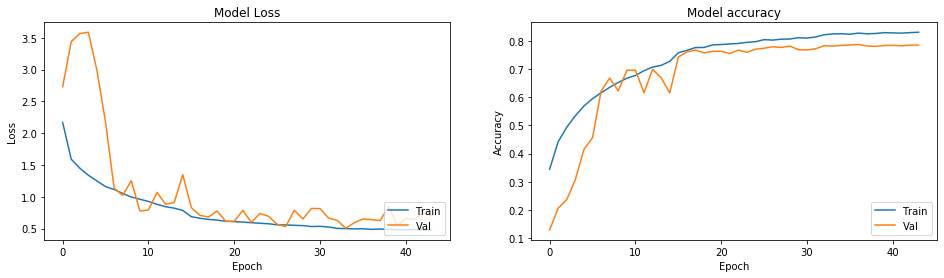

In [9]:
plot_loss_accuracy(history)

In [10]:
print('Test accuracy for benchmark model= {}'.format(conv_model.evaluate(X_test, y_test)[1]))

10000/10000 [==============================] - 1s 120us/step
Test accuracy for benchmark model= 0.7742999792098999


Classification Report:

              precision    recall  f1-score   support

    Airplane       0.80      0.81      0.80      1000
  Automobile       0.84      0.91      0.87      1000
        Bird       0.76      0.64      0.69      1000
         Cat       0.67      0.52      0.59      1000
        Deer       0.76      0.71      0.73      1000
         Dog       0.71      0.66      0.68      1000
        Frog       0.68      0.93      0.78      1000
       Horse       0.81      0.85      0.83      1000
        Ship       0.91      0.83      0.87      1000
       Truck       0.82      0.88      0.85      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



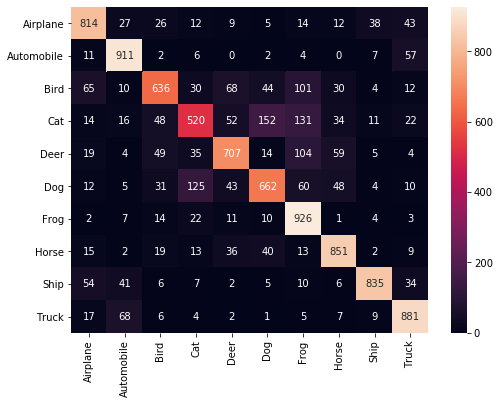

In [11]:
predictions = conv_model.predict(X_test)
report(predictions, y_test)

## Create Convolution Autoencoder

In [12]:
def create_block(input, chs): ## Convolution block of 2 layers
    x = input
    for i in range(2):
        x = Conv2D(chs, 3, padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
    return x

def loss_function(y_true, y_pred):  ## loss function for using in autoencoder models
    mses = mean_squared_error(y_true, y_pred)
    return K.sum(mses, axis=(1,2))

In [13]:
def create_convolution_ae():
    input_img = Input((32,32,3))
    
    #encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)    

    # at this point the representation is ...

    #decoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='categorical_crossentropy')
    encoder = Model(input_img, encoded)
    return encoder, autoencoder

In [14]:
# def create_convolution_ae2():
#     input = Input((32,32,3))
    
#     # Encoder
#     block1 = create_block(input, 32)
#     x = MaxPool2D(2)(block1)
#     block2 = create_block(x, 64)
#     x = MaxPool2D(2)(block2)
    
#     #Middle
#     middle = create_block(x, 128)
    
#     # Decoder
#     up1 = UpSampling2D((2,2))(middle)
#     block3 = create_block(up1, 64)
#     #up1 = UpSampling2D((2,2))(block3)
#     up2 = UpSampling2D((2,2))(block3)
#     block4 = create_block(up2, 32)
#     #up2 = UpSampling2D((2,2))(block4)
    
#     # output
#     x = Conv2D(3, 1)(up2)
#     output = Activation("sigmoid")(x)
#     return Model(input, middle), Model(input, output)

# encoder_conv, autoencoder_conv = create_convolution_ae2()
# # autoencoder.compile(loss='categorical_crossentropy', optimizer=Adadelta())  # model_ae.compile(SGD(1e-3, 0.9), loss=loss_function) 
# autoencoder_conv.summary()

In [15]:
encoder_conv, autoencoder_conv = create_convolution_ae()
# autoencoder.compile(loss='categorical_crossentropy', optimizer=Adadelta())  # model_ae.compile(SGD(1e-3, 0.9), loss=loss_function) 
autoencoder_conv.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 16)        9232      
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 16)        64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 16)          0   

In [16]:
#Train the autoencoder convolution model. No need to use labels as it is unsupervised learning
history = train_model(autoencoder_conv, X_train, X_train, X_valid, X_valid, data_aug = False, epochs=epochs, batch_size=batch_size)
print(history)

Training without data augmentation...
Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 7s 163us/step - loss: 1.5483 - val_loss: 1.5566
Epoch 2/50
40000/40000 [==============================] - 5s 124us/step - loss: 1.5419 - val_loss: 1.5550
Epoch 3/50
40000/40000 [==============================] - 5s 128us/step - loss: 1.5410 - val_loss: 1.5525
Epoch 4/50
40000/40000 [==============================] - 5s 124us/step - loss: 1.5406 - val_loss: 1.5500
Epoch 5/50
40000/40000 [==============================] - 5s 126us/step - loss: 1.5403 - val_loss: 1.5463
Epoch 6/50
40000/40000 [==============================] - 5s 124us/step - loss: 1.5403 - val_loss: 1.5431
Epoch 7/50
40000/40000 [==============================] - 5s 125us/step - loss: 1.5400 - val_loss: 1.5410
Epoch 8/50
40000/40000 [==============================] - 5s 130us/step - loss: 1.5399 - val_loss: 1.5393
Epoch 9/50
40000/40000 [==============================] - 5s 129

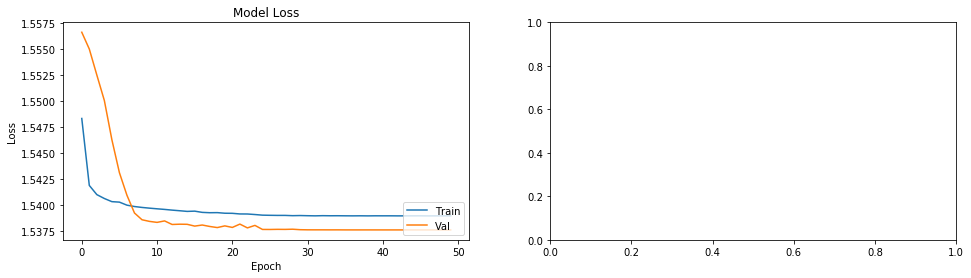

In [17]:
plot_loss_accuracy(history, plot_loss_only=True)

In [18]:
decoded_test_imgs_conv_ae = autoencoder_conv.predict(X_test)
decoded_valid_imgs_conv_ae = autoencoder_conv.predict(X_valid)

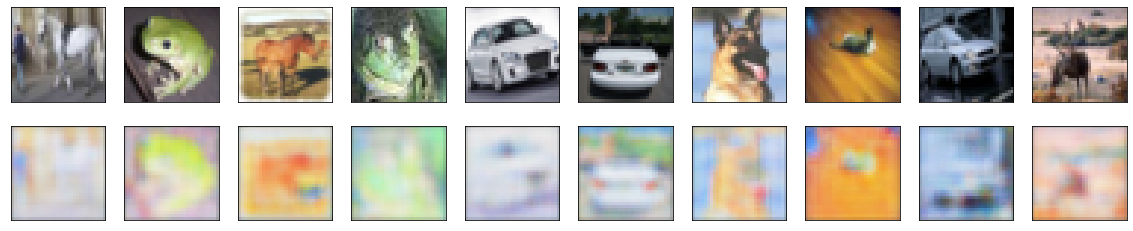

In [19]:
showOrigAndReconstructedImages(X_valid, decoded_valid_imgs_conv_ae, 32, 32, 3)

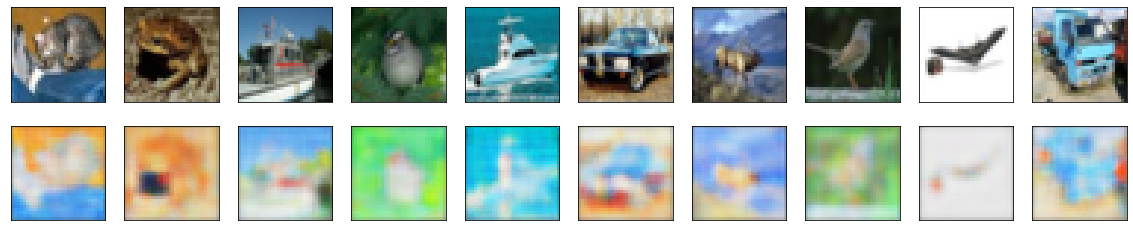

In [20]:
showOrigAndReconstructedImages(X_test, decoded_test_imgs_conv_ae, 32, 32, 3)

## Classify images using features extracted from above Autoencoder model

In [21]:
def classifier_dense(inp):
    input = Input((inp.shape[1], inp.shape[2], inp.shape[3]))
    #x = MaxPool2D()(input)
    x = Flatten()(input)
    #x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.64)(x)
    x = Dense(50, activation='relu')(x)
    #x = Reshape((-1, 1))(x)
    #x = Conv1D(128, (3,), activation='relu', padding='same')(x)
    #x = MaxPool1D()(x)
    #x = CuDNNLSTM(64)(x)
    #x = Flatten()(x)
    x = Dropout(0.4)(x)
    output = Dense(no_of_classes, activation='softmax')(x)
    return Model(input, output)

def classifier_conv(inp):
    input = Input((inp.shape[1], inp.shape[2], inp.shape[3]))
    x = Conv2D(1024, 3, padding="same")(input)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2)(x)
    x = Dropout(0.5)(x)
    
    x = Conv2D(128, 3, padding="same")(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2)(x)
    x = Dropout(0.5)(x)
    
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.35)(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.69)(x)
    
    output = Dense(no_of_classes, activation='softmax')(x)
    return Model(input, output)

def create_classifier(m, inp):  ## function for choosing dense/convolutional classifier model
    if m=='dense':
        classifier = classifier_dense(inp)
    elif m=='conv':
        classifier = classifier_conv(inp)    
    classifier.compile(loss='categorical_crossentropy', optimizer=Adadelta(), metrics=['acc'])
    return classifier

In [22]:
#Extracting bottleneck features to use as inputs in the classifier model:
gist_train_ae = encoder_conv.predict(X_train)
gist_valid_ae = encoder_conv.predict(X_valid)
gist_test_ae = encoder_conv.predict(X_test)

## Convolutional Autoencoder with simple NN or multi-layer perceptron as classifier:

In [23]:
decoder_ae_dense = create_classifier('dense', gist_train_ae)
decoder_ae_dense.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                25650     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                510 

In [24]:
history = train_model(decoder_ae_dense, gist_train_ae, y_train, gist_valid_ae, y_valid, data_aug = False, epochs=epochs, batch_size=batch_size)

Training without data augmentation...
Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 1s 21us/step - loss: 2.1619 - acc: 0.2255 - val_loss: 1.8583 - val_acc: 0.3219
Epoch 2/50
40000/40000 [==============================] - 1s 15us/step - loss: 1.9180 - acc: 0.3079 - val_loss: 1.7164 - val_acc: 0.3882
Epoch 3/50
40000/40000 [==============================] - 1s 15us/step - loss: 1.8248 - acc: 0.3387 - val_loss: 1.6493 - val_acc: 0.3965
Epoch 4/50
40000/40000 [==============================] - 1s 14us/step - loss: 1.7681 - acc: 0.3647 - val_loss: 1.6053 - val_acc: 0.4181
Epoch 5/50
40000/40000 [==============================] - 1s 14us/step - loss: 1.7111 - acc: 0.3848 - val_loss: 1.5955 - val_acc: 0.4300
Epoch 6/50
40000/40000 [==============================] - 1s 15us/step - loss: 1.6819 - acc: 0.3945 - val_loss: 1.5840 - val_acc: 0.4247
Epoch 7/50
40000/40000 [==============================] - 1s 14us/step - loss: 1.6485 - ac

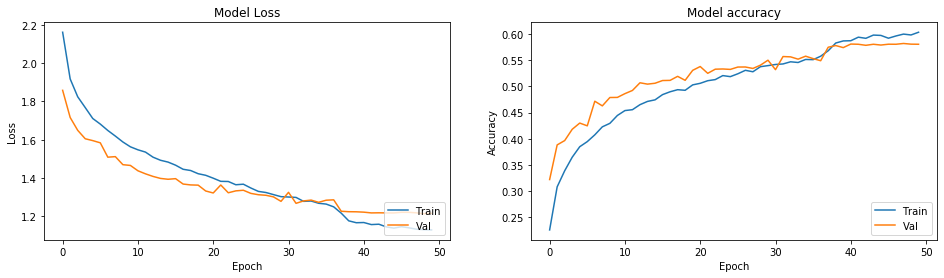

In [25]:
plot_loss_accuracy(history)

In [26]:
print('Test accuracy for AE_dense model= {}'.format(decoder_ae_dense.evaluate(gist_test_ae, y_test)[1]))

10000/10000 [==============================] - 1s 64us/step
Test accuracy for AE_dense model= 0.5776000022888184


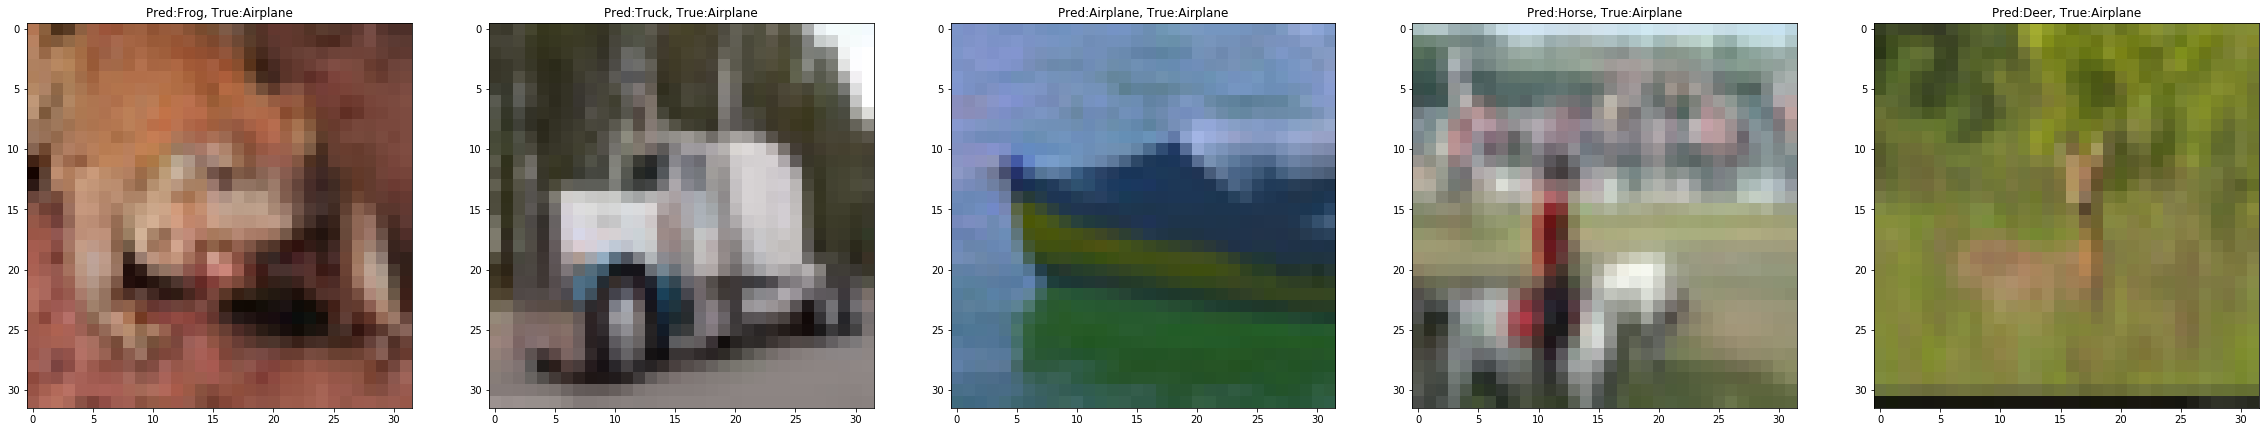

In [27]:
show_test(decoder_ae_dense, X_test, y_test, gist_test_ae)

Classification Report:

              precision    recall  f1-score   support

    Airplane       0.64      0.63      0.63      1000
  Automobile       0.68      0.68      0.68      1000
        Bird       0.53      0.39      0.45      1000
         Cat       0.39      0.44      0.41      1000
        Deer       0.53      0.49      0.51      1000
         Dog       0.50      0.43      0.46      1000
        Frog       0.58      0.69      0.63      1000
       Horse       0.62      0.66      0.64      1000
        Ship       0.68      0.71      0.69      1000
       Truck       0.61      0.66      0.64      1000

    accuracy                           0.58     10000
   macro avg       0.58      0.58      0.57     10000
weighted avg       0.58      0.58      0.57     10000



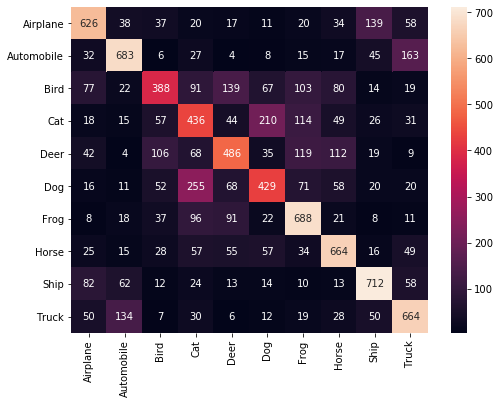

In [28]:
predictions = decoder_ae_dense.predict(gist_test_ae)
report(predictions, y_test)

## Convolutional Autoencoder with CNN as classifier:

In [29]:
decoder_ae_conv = create_classifier('conv', gist_train_ae)
decoder_ae_conv.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 1024)        148480    
_________________________________________________________________
activation_5 (Activation)    (None, 8, 8, 1024)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 8, 1024)        4096      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 1024)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 128)         1179

In [30]:
hist = train_model(decoder_ae_conv, gist_train_ae, y_train, gist_valid_ae, y_valid, data_aug = False, epochs=epochs, batch_size=batch_size)

Training without data augmentation...
Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 5s 130us/step - loss: 2.3776 - acc: 0.1589 - val_loss: 2.1584 - val_acc: 0.2383
Epoch 2/50
40000/40000 [==============================] - 4s 96us/step - loss: 2.1085 - acc: 0.2059 - val_loss: 1.9419 - val_acc: 0.3127
Epoch 3/50
40000/40000 [==============================] - 4s 95us/step - loss: 1.9618 - acc: 0.2585 - val_loss: 1.8409 - val_acc: 0.3491
Epoch 4/50
40000/40000 [==============================] - 4s 95us/step - loss: 1.8607 - acc: 0.2939 - val_loss: 1.7351 - val_acc: 0.3780
Epoch 5/50
40000/40000 [==============================] - 4s 95us/step - loss: 1.7930 - acc: 0.3257 - val_loss: 1.6360 - val_acc: 0.4081
Epoch 6/50
40000/40000 [==============================] - 4s 95us/step - loss: 1.7371 - acc: 0.3568 - val_loss: 1.6587 - val_acc: 0.4044
Epoch 7/50
40000/40000 [==============================] - 4s 95us/step - loss: 1.6709 - a

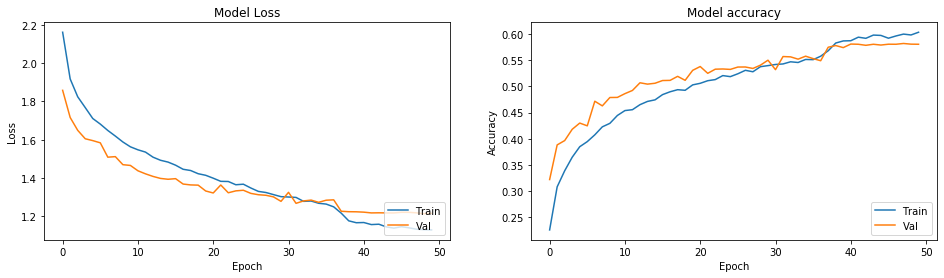

In [31]:
plot_loss_accuracy(history)

In [32]:
print('Test accuracy for AE_conv model= {}'.format(decoder_ae_conv.evaluate(gist_test_ae, y_test)[1]))

10000/10000 [==============================] - 1s 125us/step
Test accuracy for AE_conv model= 0.6615999937057495


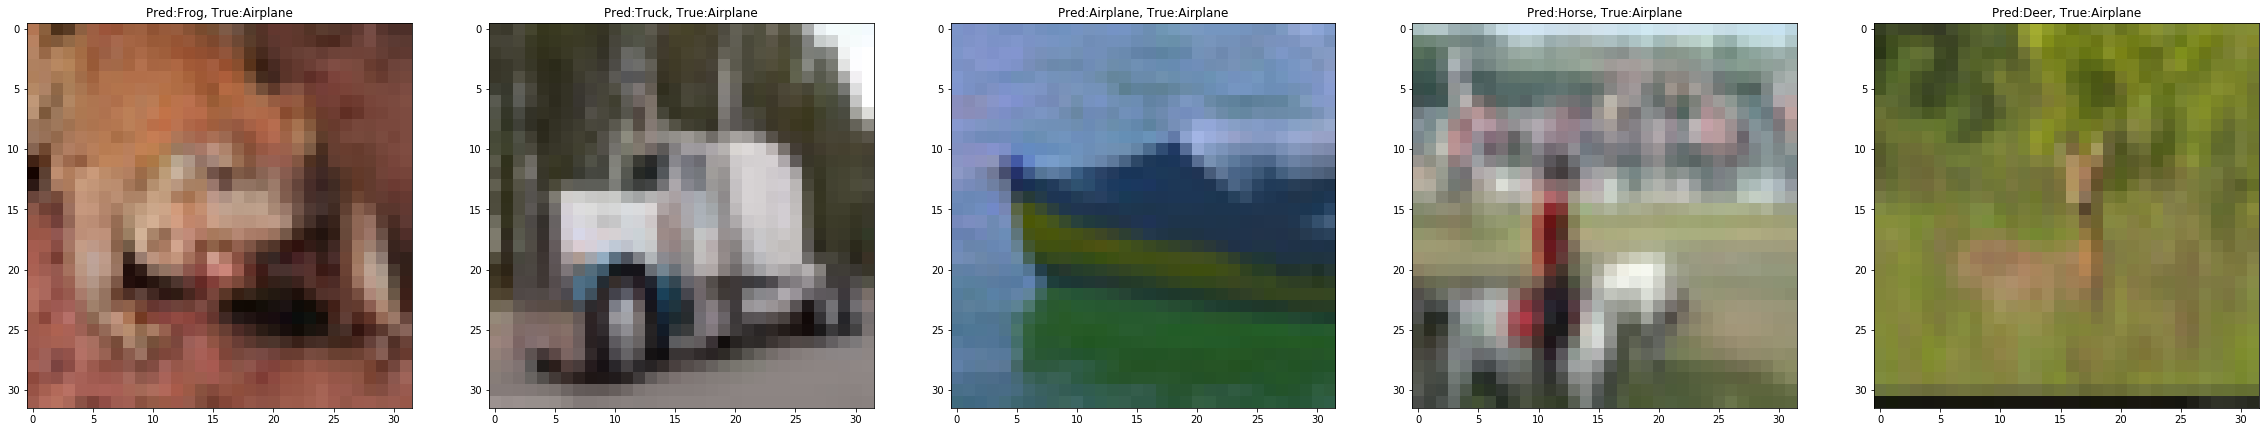

In [33]:
show_test(decoder_ae_conv, X_test, y_test, gist_test_ae)

Classification Report:

              precision    recall  f1-score   support

    Airplane       0.74      0.69      0.71      1000
  Automobile       0.78      0.78      0.78      1000
        Bird       0.67      0.46      0.55      1000
         Cat       0.45      0.41      0.43      1000
        Deer       0.60      0.61      0.61      1000
         Dog       0.54      0.61      0.57      1000
        Frog       0.66      0.78      0.72      1000
       Horse       0.69      0.75      0.72      1000
        Ship       0.77      0.79      0.78      1000
       Truck       0.71      0.73      0.72      1000

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.66     10000
weighted avg       0.66      0.66      0.66     10000



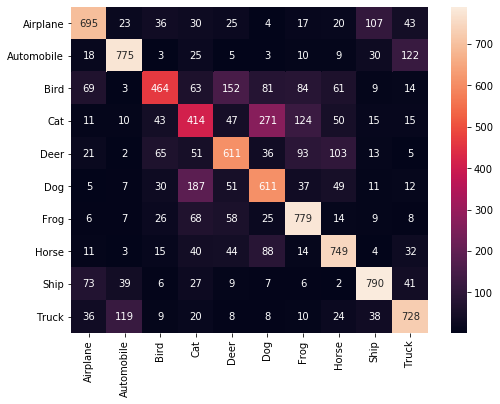

In [34]:
predictions = decoder_ae_conv.predict(gist_test_ae)
report(predictions, y_test)

## References:
* https://blog.keras.io/building-autoencoders-in-keras.html
* https://www.kaggle.com/aninditapani/cifar-10-cnn-from-scratch
* https://www.kaggle.com/mahtabshaan/autoencoder-as-feature-extractor-cifar10
* https://www.kaggle.com/amithasanshuvo/cifar-images-classification-using-cnn